In [1]:
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from tslearn.preprocessing import TimeSeriesScalerMinMax
sys.path.append(os.path.join(os.path.dirname('Demand'), '..', 'src'))
from Demand import Demand

In [2]:
path = '../data/demand_lower_48'

In [3]:
nat_dem = Demand()

In [4]:
nat_dem.load_and_clean_data(path)

In [5]:
df = nat_dem.dataframe

In [20]:
def create_X_matrix(y_train, seq_len):
    X = []
    for i in range(seq_len, len(y_train)):
        X.append(y_train[i-seq_len:i])
    return np.array(X)

In [7]:
split_index = 40919

In [8]:
y = df['Megawatthours'].values

In [9]:
y

array([335153, 333837, 398386, ..., 371950, 379932, 390453])

In [10]:
scaler = MinMaxScaler()

In [13]:
y_train = y[:split_index]
y_test = y[split_index:]
y_train.shape

(40919,)

In [14]:
y_test.shape

(9260,)

In [16]:
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

In [17]:
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [21]:
seq_len=20

In [22]:
X_train = create_X_matrix(y_train_scaled, seq_len)

In [24]:
X_train.shape

(40899, 20, 1)

In [25]:
y_train_scaled = y_train_scaled[seq_len:]
y_train_scaled.shape

(40899, 1)

## RNN model fit

In [26]:
rnn_model = Sequential()

In [27]:
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [30]:
rnn_model.compile(optimizer='adam', loss='MAE')
rnn_model.fit(X_train, y_train_scaled, epochs=80, batch_size=1000)

Epoch 1/80
41/41 [==============================] - 1s 25ms/step - loss: 0.3736
Epoch 2/80
41/41 [==============================] - 1s 24ms/step - loss: 0.2112
Epoch 3/80
41/41 [==============================] - 1s 23ms/step - loss: 0.1260
Epoch 4/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0885
Epoch 5/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0685
Epoch 6/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0573
Epoch 7/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0504
Epoch 8/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0452
Epoch 9/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0410
Epoch 10/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0385
Epoch 11/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0363
Epoch 12/80
41/41 [==============================] - 1s 23ms/step - loss: 0.0340
Epoch 13/80
41/41 [==================

## RNN model predict

In [218]:
def get_rnn_predictions(y_train_scaled, model, preds_length, seq_len=20):
    preds = np.zeros(preds_length).reshape(-1, 1)
    for i in range(seq_len):
        X_matrix = np.concatenate((y_train_scaled[-(seq_len-i):], preds[:i].reshape(-1, 1)))
        X_matrix = X_matrix.reshape(1, seq_len, 1)
        p = model.predict(X_matrix)[0, 0]
        preds[i]=p
    for j in range(seq_len, preds_length):
        X_matrix = preds[j-seq_len:j, 0]
        X_matrix = X_matrix.reshape(1, seq_len, 1)
        p = model.predict(X_matrix)[0, 0]
        preds[j]=p
    return preds

    
        

In [223]:
y_preds = get_rnn_predictions(y_train_scaled, rnn_model, len(y_test_scaled), 20)

In [242]:
y_preds[0:200]

array([[0.35661036],
       [0.34685189],
       [0.34490144],
       [0.3497    ],
       [0.36297786],
       [0.38691008],
       [0.41959488],
       [0.45357925],
       [0.48000979],
       [0.49136505],
       [0.48432425],
       [0.4633525 ],
       [0.43615672],
       [0.41093671],
       [0.39347091],
       [0.38585487],
       [0.3890067 ],
       [0.40132987],
       [0.42025486],
       [0.44100592],
       [0.45714384],
       [0.46359915],
       [0.45929748],
       [0.44732568],
       [0.43344632],
       [0.42373887],
       [0.42259735],
       [0.43173391],
       [0.45001608],
       [0.47421643],
       [0.49958411],
       [0.52063632],
       [0.5325712 ],
       [0.53249133],
       [0.52064824],
       [0.50052428],
       [0.47787133],
       [0.45878804],
       [0.44784272],
       [0.44702289],
       [0.45559734],
       [0.47056872],
       [0.48756626],
       [0.50198257],
       [0.51015651],
       [0.51041371],
       [0.50360823],
       [0.492

In [243]:
y_preds[9200:]

array([[0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.57262671],
       [0.572

In [227]:
mae = mean_absolute_error(y_test_scaled, y_preds)
mae

0.2171529484727215

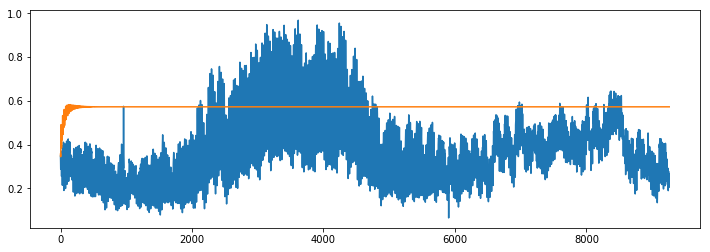

In [245]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(y_test_scaled)), y_test_scaled)
ax.plot(range(len(y_test_scaled)), y_preds)
plt.show()